<a href="https://colab.research.google.com/github/FabioRovai/AGChatbot/blob/main/trykpt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [194]:
#@title Download a list of PDB files from the dunbrack lab. 
%matplotlib inline
#%tensorflow_version 1.x
import tensorflow as tf
import zipfile
import os 
import shutil 
import pandas as pd
import sys
import numpy as np
import requests 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import soundfile as sf
import re
import IPython
import IPython.display as ipd
from IPython.display import clear_output 
import random
import warnings
warnings.filterwarnings("ignore")

#sim infos https://www.ncbi.nlm.nih.gov/Structure/vastplus/vastplus.cgi and https://fatcat.godziklab.org/fatcat/fatcat_pair.html
# Download infos
# The following to code blocks allow for downloading a list of PDB files from Dr. Dunbrack Lab website.
# There is an example for one protein, but if you have a list "protein_IDs" then you could loop through them, 
# download each file, extract the coordinates, and add them to the protein_coordinates dict. 
# I would recommend downloaded a list from here: http://dunbrack.fccc.edu/Guoli/culledpdb_hh/cullpdb_pc25_res1.8_R0.25_d2021_07_02_chains6104.gz
# If you convert the file ending from .gz to .txt, you will get a list of protein structure IDs. 
# The ID is five symbols long; the first four symbols are the protein ID and the fifth is the chain ID. 
# You should only keep the protein IDs with the "XRAY" method. Without going to deep into the details, 
# the above list contains IDs for high-quality, non-redundant structures

# Download PDB file
!wget  https://raw.githubusercontent.com/FabioRovai/test7/main/PDB.txt -O PDB.txt --quiet

# Read PDB file with Pandas

pdb=pd.read_csv ('PDB.txt', delim_whitespace=True, header=0)
pdb.sort_values(by=['length'])
pdb.head(10)


,IDs,length,Exptl.,resolution,R-factor,FreeRvalue
0,1A62A,130,XRAY,1.550,0.22,0.25
1,1A73A,163,XRAY,1.800,0.21,0.30
2,1A7EA,118,XRAY,1.800,0.19,0.23
3,1A9XF,379,XRAY,1.800,0.19,1.00
4,1AH7A,245,XRAY,1.501,0.20,0.23
5,1AHOA,64,XRAY,0.960,0.16,1.00
6,1ATZB,189,XRAY,1.800,0.17,0.24
7,1AZOA,232,XRAY,1.700,0.20,0.26
8,1B5EA,246,XRAY,1.600,0.19,0.21
9,1B9WA,95,XRAY,1.800,0.21,0.28


In [195]:
#@title  Choose your PDB file directly from RCSB PDB

# Define protein ID (2IVN sounds good)
#full_protein_ID ='1AZOA'#@param {type:"string"}  
#protein_ID = pdb.IDs.loc[pdb.iloc[:,0].str.contains(full_protein_ID)].iloc[0][:-1]
protein_ID='1A62'
#full_protein_ID ='6DUQ' #use this if not in the refence file
#PDB.IDs.iloc[100][:-1] by index
# Define url and download data
url = 'https://files.rcsb.org/download/{}.pdb'.format(protein_ID.lower())
response = requests.get(url)
data = response.text

# Split data into array using newline as delimiter
text = data.split("\n") 

# Gather the coordinates for each c-alpha atom
ca_coordinates = []

for line in text:
  # Matches lines beginning with 'ATOM'
  if 'ATOM' == line[0:4] or 'HETATOM' == line[0:7]:
    # Matches lines with c-alpha coordinates, altLoc A or ' ', and chain A
    # If using the dunbrack list the final == statement should be line[21] == protein_ID[4] (the fifth character)
    if line[13:15] == 'CA' and line[16] in ['A',' '] and line[21] == 'A': 
      # Extract x, y, and z coordinates and 
      # add to coordinates list
      x = float(line[30:38])      
      y = float(line[38:46])     
      z = float(line[46:54])
      ca_coordinates.append([x,y,z])

# Save coordinates as array
ca_coordinates = np.asarray(ca_coordinates)
x= ca_coordinates[:,0]
y= ca_coordinates[:,1]
z= ca_coordinates[:,2]

# Store coordinates in 3 different files (x,y,z.txt)- as a string
with open("x.txt", "w") as variable_file:
    variable_file.write(str(x))
with open("y.txt", "w") as variable_file:
    variable_file.write(str(y))
with open("z.txt", "w") as variable_file:
    variable_file.write(str(z))

# Convert coordinates to dataframe and store them again (cleaner for R reading)
PDB = pd.DataFrame(x, index=None)
PDB2 = pd.DataFrame(y, index=None)
PDB3 = pd.DataFrame(z, index=None)
PDB.to_csv('/content/f.txt', sep='\t', index=False)
PDB2.to_csv('/content/ff.txt', sep='\t', index=False)
PDB3.to_csv('/content/fff.txt', sep='\t', index=False)


import numpy as np


dist = (PDB - PDB2)**2
dist = np.sum(dist, axis=1)
xy = np.sqrt(dist)

with open("xy.txt", "w") as variable_file:
    variable_file.write(str(xy))
PDBxy = pd.DataFrame(xy, index=None)
PDB.to_csv('/content/xy.txt', sep='\t', index=False)

#https://stackoverflow.com/questions/61081943/how-to-plot-sine-wave-in-python-with-sudden-amplitude-change

print ('Coordinates for each c-alpha atom of',protein_ID,'have been successfully extracted.')

Coordinates for each c-alpha atom of 1A62 have been successfully extracted.


In [196]:
# convex hull (Graham scan by x-coordinate) and diameter of a set of points
# David Eppstein, UC Irvine, 7 Mar 2002
from __future__ import generators
def orientation(p,q,r):
    '''Return positive if p-q-r are clockwise, neg if ccw, zero if colinear.'''
    return (q[1]-p[1])*(r[0]-p[0]) - (q[0]-p[0])*(r[1]-p[1])
def hulls(Points):
    '''Graham scan to find upper and lower convex hulls of a set of 2d points.'''
    U = []
    L = []
    #Points.sort()
    for p in Points:
        while len(U) > 1 and orientation(U[-2],U[-1],p) <= 0: U.pop()
        while len(L) > 1 and orientation(L[-2],L[-1],p) >= 0: L.pop()
        U.append(p)
        L.append(p)
    return U,L
def rotatingCalipers(Points):
    '''Given a list of 2d points, finds all ways of sandwiching the points
between two parallel lines that touch one point each, and yields the sequence
of pairs of points touched by each pair of lines.'''
    U,L = hulls(Points)
    i = 0
    j = len(L) - 1
    while i < len(U) - 1 or j > 0:
        yield U[i],L[j]
        # if all the way through one side of hull, advance the other side
        if i == len(U) - 1: j -= 1
        elif j == 0: i += 1
        # still points left on both lists, compare slopes of next hull edges
        # being careful to avoid divide-by-zero in slope calculation
        elif (U[i+1][1]-U[i][1])*(L[j][0]-L[j-1][0]) > \
                (L[j][1]-L[j-1][1])*(U[i+1][0]-U[i][0]):
            i += 1
        else: j -= 1
def diameter(Points):
    '''Given a list of 2d points, returns the pair that's farthest apart.'''
    diam,pair = max([((p[0]-q[0])**2 + (p[1]-q[1])**2, (p,q))
                     for p,q in rotatingCalipers(Points)])
    return pair


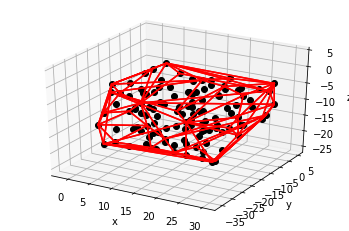

In [197]:
#MAX Width?

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#https://flothesof.github.io/farthest-neighbors.html
# 8 points defining the cube corners
pts = ca_coordinates
hull = ConvexHull(pts)
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "r-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))

foo=hull.simplices.tolist()
foo=pts[s]
import itertools
baz = list(itertools.chain(*foo))
def incremental_farthest_search(points, k):
    remaining_points = points[:]
    solution_set = []
    centroid=np.sum(ca_coordinates,axis=0)/len(ca_coordinates)
    #mean_centroid=int(np.mean(centroid))
    mean=int(np.mean(baz))
    solution_set.append(remaining_points.pop(\
                                             (mean - 1)))
    for _ in range(k-1):
        distances = [distance(p, solution_set[0]) for p in remaining_points]
        for i, p in enumerate(remaining_points):
            for j, s in enumerate(solution_set):
                distances[i] = min(distances[i], distance(p, s))
        solution_set.append(remaining_points.pop(distances.index(max(distances))))
    return solution_set
def distance(A, B):
    return abs(A - B)

bar=incremental_farthest_search(baz,2)
max_width = np.linalg.norm(bar[0] - bar[1])
max_width
plt.show()

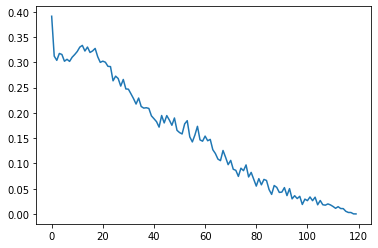

In [198]:
from sklearn.metrics import silhouette_score

sil = []
kmax = len(ca_coordinates)-1

for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(ca_coordinates)
  labels = kmeans.labels_
  sil.append(silhouette_score(ca_coordinates, labels, metric = 'euclidean'))

plt.plot(sil)

1 : 13.781843014202718
2 : 10.06406977818382
3 : 8.885445494148295
4 : 7.948138405503003
5 : 7.27953480776352
6 : 6.75352956871629
7 : 6.3590538335240145
8 : 5.949475486891297
9 : 5.630093584027341


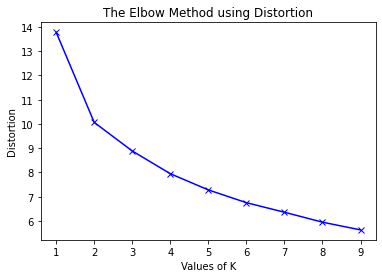

In [212]:
K = range(1, 10)
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
#https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
X=ca_coordinates
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_


for key, val in mapping1.items():
    print(f'{key} : {val}')


plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [220]:
from sklearn.cluster import KMeans
 
#Initialize the class object
kmeans = KMeans(n_clusters= 2)
 
#predict the labels of clusters.
label = kmeans.fit_predict(X)
 
print(label)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1]


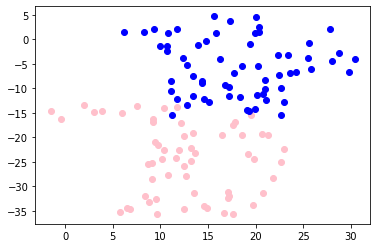

In [224]:
#filter rows of original data
filtered_label2 = X[label == 0]
 
filtered_label8 = X[label == 1]
 
#Plotting the results
plt.scatter(filtered_label2[:,0] , filtered_label2[:,1] , color = 'pink')
plt.scatter(filtered_label8[:,0] , filtered_label8[:,1] , color = 'blue')
plt.show()

Convex Hull Volume: 14148.274420364836
Farthest Distance 2D: 43.709072216188716
Farthest Distance 3D (Widest Points): 47.017
Centroid: [ 15.36733607 -14.7934918  -10.90055738]
Points in Positive X: 37
Points in Negative X: 85
Points in Positive Y: 65
Points in Negative Y: 57
Points in Positive Z: 65
Points in Negative Z: 57


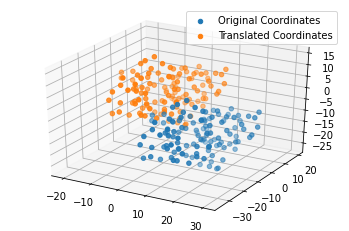

In [203]:
#@title  Calculate Volume of Convex Hull, Farthest Distance using Rotating Calipers and Centroid and Calculate number of positive and negative points on each axis 
# Calculate Volume of Convex Hull and Centroid
from scipy.spatial import ConvexHull
from scipy.io import wavfile
hull_volume=ConvexHull(ca_coordinates).volume
print("Convex Hull Volume:",hull_volume)
# Calculate Max Distance using rotating caliper
max_points = list(diameter(ca_coordinates))
max_distance = np.linalg.norm(max_points[0] - max_points[1])
print("Farthest Distance 2D:",max_distance)
print("Farthest Distance 3D (Widest Points):",max_width)
centroid = np.sum(ca_coordinates,axis=0)/len(ca_coordinates)
print("Centroid:",centroid)
# Translate structure to be centered on centroid
closest_dist = np.linalg.norm(ca_coordinates[0]-centroid)
closest_point = 0
for i in range(len(ca_coordinates)):
  p = ca_coordinates[i]
  if np.linalg.norm(p-centroid) < closest_dist:
    closest_dist = np.linalg.norm(p-centroid)
    closest_point = i
translated_ca_coors = []
for i in range(len(ca_coordinates)):
  p = ca_coordinates[i]
  translated_ca_coors.append(p-ca_coordinates[closest_point])
translated_ca_coors = np.asarray(translated_ca_coors)
# Calculate number of positive and negative points on each axis 
pos_neg_xyz = [0,0,0,0,0,0]
for i in range(len(translated_ca_coors)):
  p = translated_ca_coors[i]
  if p[0] > 0:
    pos_neg_xyz[0]+=1
  else:
    pos_neg_xyz[1]+=1
  if p[1] > 0:
    pos_neg_xyz[2]+=1
  else:
    pos_neg_xyz[3]+=1
  if p[1] > 0:
    pos_neg_xyz[4]+=1
  else:
    pos_neg_xyz[5]+=1
print("Points in Positive X:",pos_neg_xyz[0])
print("Points in Negative X:",pos_neg_xyz[1])
print("Points in Positive Y:",pos_neg_xyz[2])
print("Points in Negative Y:",pos_neg_xyz[3])
print("Points in Positive Z:",pos_neg_xyz[4])
print("Points in Negative Z:",pos_neg_xyz[5])

#Plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(ca_coordinates[:,0],ca_coordinates[:,1],ca_coordinates[:,2],label='Original Coordinates')
ax.scatter(translated_ca_coors[:,0],translated_ca_coors[:,1],translated_ca_coors[:,2],label='Translated Coordinates')
plt.legend()
plt.show()

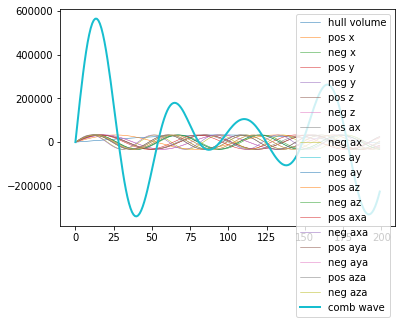

In [200]:
#@title  Add characteristics to wave
samplerate = 44100
# Volume wave
hull_volume_freq = hull_volume/1000 # scaling down a bit
t = np.linspace(0., 10., samplerate)/(len(ca_coordinates)/100)
amplitude = np.iinfo(np.int16).max
volume_signal = amplitude * np.sin(2. * np.pi * hull_volume_freq * t)
# Pos X wave
pos_x = amplitude * np.sin(2. * np.pi * (hull_volume_freq+pos_neg_xyz[0]) * t)
# Neg X wave
neg_x = amplitude * np.sin(2. * np.pi * (hull_volume_freq+pos_neg_xyz[1]) * t)
# Pos Y wave
pos_y = amplitude * np.sin(2. * np.pi * (hull_volume_freq+pos_neg_xyz[2]) * t)
# Neg X wave
neg_y = amplitude * np.sin(2. * np.pi * (hull_volume_freq+pos_neg_xyz[3]) * t)
# Pos Z wave
pos_z = amplitude * np.sin(2. * np.pi * (hull_volume_freq+pos_neg_xyz[4]) * t)
# Neg Z wave
neg_z = amplitude * np.sin(2. * np.pi * (hull_volume_freq+pos_neg_xyz[5]) * t)
# Pos X wave
pos_ax = amplitude * np.sin(2. * np.pi * (max_distance+pos_neg_xyz[0]) * t)
# Neg X wave
neg_ax = amplitude * np.sin(2. * np.pi * (max_distance+pos_neg_xyz[1]) * t)
# Pos Y wave
pos_ay = amplitude * np.sin(2. * np.pi * (max_distance+pos_neg_xyz[2]) * t)
# Neg X wave
neg_ay = amplitude * np.sin(2. * np.pi * (max_distance+pos_neg_xyz[3]) * t)
# Pos Z wave
pos_az = amplitude * np.sin(2. * np.pi * (max_distance+pos_neg_xyz[4]) * t)
# Neg Z wave
neg_az = amplitude * np.sin(2. * np.pi * (max_distance+pos_neg_xyz[5]) * t)

# Pos X wave
pos_axa = amplitude * np.sin(2. * np.pi * (max_width+pos_neg_xyz[0]) * t)
# Neg X wave
neg_axa = amplitude * np.sin(2. * np.pi * (max_width+pos_neg_xyz[1]) * t)
# Pos Y wave
pos_aya = amplitude * np.sin(2. * np.pi * (max_width+pos_neg_xyz[2]) * t)
# Neg X wave
neg_aya = amplitude * np.sin(2. * np.pi * (max_width+pos_neg_xyz[3]) * t)
# Pos Z wave
pos_aza = amplitude * np.sin(2. * np.pi * (max_width+pos_neg_xyz[4]) * t)
# Neg Z wave
neg_aza = amplitude * np.sin(2. * np.pi * (max_width+pos_neg_xyz[5]) * t)


# Combination wave
data = volume_signal + pos_x + neg_x + pos_y + neg_y + pos_z + neg_z + pos_ax + neg_ax + pos_ay + neg_ay + pos_az + neg_az + pos_axa + neg_axa + pos_aya + neg_aya + pos_aza + neg_aza 

# Plot
n = 200
plt.plot(volume_signal[0:n],label='hull volume',linewidth=0.5)
plt.plot(pos_x[0:n],label='pos x',linewidth=0.5)
plt.plot(neg_x[0:n],label='neg x',linewidth=0.5)
plt.plot(pos_y[0:n],label='pos y',linewidth=0.5)
plt.plot(neg_y[0:n],label='neg y',linewidth=0.5)
plt.plot(pos_z[0:n],label='pos z',linewidth=0.5)
plt.plot(neg_z[0:n],label='neg z',linewidth=0.5)
plt.plot(pos_ax[0:n],label='pos ax',linewidth=0.5)
plt.plot(neg_ax[0:n],label='neg ax',linewidth=0.5)
plt.plot(pos_ay[0:n],label='pos ay',linewidth=0.5)
plt.plot(neg_ay[0:n],label='neg ay',linewidth=0.5)
plt.plot(pos_az[0:n],label='pos az',linewidth=0.5)
plt.plot(neg_az[0:n],label='neg az',linewidth=0.5)
plt.plot(pos_axa[0:n],label='pos axa',linewidth=0.5)
plt.plot(neg_axa[0:n],label='neg axa',linewidth=0.5)
plt.plot(pos_aya[0:n],label='pos aya',linewidth=0.5)
plt.plot(neg_aya[0:n],label='neg aya',linewidth=0.5)
plt.plot(pos_aza[0:n],label='pos aza',linewidth=0.5)
plt.plot(neg_aza[0:n],label='neg aza',linewidth=0.5)
plt.plot(data[0:n],label='comb wave',linewidth=2)
plt.legend()
plt.show()

In [201]:
#@title  Rescale, store and retrive
# Rescale data because adding waves increases the amplitude beyond the limit
data += -(np.min(data))
data /= np.max(data) / (np.iinfo(np.int16).max - np.iinfo(np.int16).min)
data += np.iinfo(np.int16).min
wavfile.write('test_wave.wav', 44100, data.astype(np.int16))

# Store and retrive signal
bigData=pd.DataFrame(data,columns=[protein_ID]) #protein_ID
retrive=bigData.iloc[:,0].to_numpy()
wavfile.write('retrive.wav', 44100, data.astype(np.int16))
IPython.display.Audio("test_wave.wav")
#IPython.display.Audio('retrive.wav')

In [202]:
b=bigData.values.tolist()
pdb=pdb.T
pdb.rename(columns=pdb.iloc[0], inplace = True)
pdb.at[0, str(full_protein_ID)] = b
pdb=pdb.T
pdb=pdb.reset_index(drop=True)
pdb.rename(columns={ pdb.columns[6]: "Sounds" }, inplace = True)


NameError: ignored

In [ ]:
retrive=bigData.iloc[:7].to_numpy()
wavfile.write('retrive.wav', 44100, data.astype(np.int16))
IPython.display.Audio("test_wave.wav")